In [41]:
import requests
from bs4 import BeautifulSoup

import spacy
import pandas as pd
import requests
from spacy import displacy
from spacy.tokens import Span
from spacy.matcher import Matcher
 
import matplotlib.pyplot as plot
from tqdm import tqdm
import networkx as ntx

In [5]:
url = ['https://thehimalayantimes.com/world/indian-farmers-reject-government-offer-and-say-they-will-carry-on-marching-to-new-delhi-28849',
       'https://thehimalayantimes.com/nepal/japanese-to-provide-grant-assistance-for-new-health-post-in-sindhuli',
       'https://thehimalayantimes.com/business/trade-deficit-reaches-rs811-billion-in-first-seven-months',
       'https://thehimalayantimes.com/business/gold-prices-dip-by-rs-400-silver-falls-rs-15-per-tola-in-domestic-market',
       'https://thehimalayantimes.com/nepal/president-paudel-to-inaugurate-5555-kg-bell-in-panchakot',
       'https://thehimalayantimes.com/business/nepse-drops-near-2000-points-amidst-market-fluctuations',
       'https://thehimalayantimes.com/nepal/over-150000-cases-yet-to-be-settled',
       'https://thehimalayantimes.com/kathmandu/kathmandu-rainfall-forces-diversion-of-intl-flight',
       'https://thehimalayantimes.com/photo-gallery/in-pictures-daily-life-at-brick-kiln',
       'https://thehimalayantimes.com/nepal/bharatpur-comes-out-first-in-performance-evaluation']

In [6]:
articles = []
for i in range(len(url)):
    response = requests.get(url[i])
    soup = BeautifulSoup(response.text, 'html.parser')
    article = soup.find('div', class_='dropcap column-1 animate-box').find_all('p')
    article = (' ').join([article[i].get_text() for i in range(1, len(article))])
    articles.append(article)

In [10]:
articles

['Indian farmers who have been protesting for a week to demand guaranteed crop prices have rejected a proposal from the government, and say they will continue their march to the capital New Delhi. The protesting farmers began their march last week, but their efforts to reach the city have been blocked by authorities, who have barricaded highways into the capital with cement blocks, metal containers, barbed wire and iron spikes to barricade highways to the capital to avoid a repeat of the 2021 farmers\' protests, during which they camped in the city\'s outskirts for over a year. The farmers are seeking a law that would guarantee minimum prices for 23 crops. Late Monday night, farm leaders said they refused the government\'s offer of a five-year contract for guaranteed prices for five crops, including pulses, maize and cotton. The government\'s proposal made Sunday was "not in the interest of farmers," Jagjit Singh Dallewal, one of the leaders of the protest, told the Press Trust of Indi

In [11]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_trf")

In [12]:
doc = nlp(articles[0])

sentences = [sent.text for sent in doc.sents]
sentences

['Indian farmers who have been protesting for a week to demand guaranteed crop prices have rejected a proposal from the government, and say they will continue their march to the capital New Delhi.',
 "The protesting farmers began their march last week, but their efforts to reach the city have been blocked by authorities, who have barricaded highways into the capital with cement blocks, metal containers, barbed wire and iron spikes to barricade highways to the capital to avoid a repeat of the 2021 farmers' protests, during which they camped in the city's outskirts for over a year.",
 'The farmers are seeking a law that would guarantee minimum prices for 23 crops.',
 "Late Monday night, farm leaders said they refused the government's offer of a five-year contract for guaranteed prices for five crops, including pulses, maize and cotton.",
 'The government\'s proposal made Sunday was "not in the interest of farmers," Jagjit Singh Dallewal, one of the leaders of the protest, told the Press 

In [13]:
def extract_entities(sents):
   # chunk one
   enti_one = ""
   enti_two = ""
  
   dep_prev_token = "" # dependency tag of previous token in sentence
  
   txt_prev_token = "" # previous token in sentence
  
   prefix = ""
   modifier = ""
  
  
  
   for tokn in nlp(sents):
       # chunk two
       ## move to next token if token is punctuation
      
       if tokn.dep_ != "punct":
           #  check if token is compound word or not
           if tokn.dep_ == "compound":
               prefix = tokn.text
               # add the current word to it if the previous word is 'compound’
               if dep_prev_token == "compound":
                   prefix = txt_prev_token + " "+ tokn.text
                  
           # verify if token is modifier or not
           if tokn.dep_.endswith("mod") == True:
               modifier = tokn.text
               # add it to the current word if the previous word is 'compound'
               if dep_prev_token == "compound":
                   modifier = txt_prev_token + " "+ tokn.text
                  
           # chunk3
           if tokn.dep_.find("subj") == True:
               enti_one = modifier +" "+ prefix + " "+ tokn.text
               prefix = ""
               modifier = ""
               dep_prev_token = ""
               txt_prev_token = ""
              
           # chunk4
           if tokn.dep_.find("obj") == True:
               enti_two = modifier +" "+ prefix +" "+ tokn.text
              
           # chunk 5
           # update variable
           dep_prev_token = tokn.dep_
           txt_prev_token = tokn.text
          
   return [enti_one.strip(), enti_two.strip()]

In [32]:
def obtain_relation(sent):
    
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)

    pattern = [{'DEP':'ROOT'},
               {'DEP':'prep','OP':"?"}, 
               {'DEP':'agent','OP':"?"}, 
               {'POS':'ADJ','OP':"?"}]

    matcher.add("matching_1", [pattern])
    matches = matcher(doc)
    h = len(matches) - 1

    span = doc[matches[h][1]:matches[h][2]]
    return span.text

In [20]:
extract_entities(sentences[3])

['they', 'five year pulses']

In [33]:
obtain_relation(sentences[1])

'began'

In [34]:
pairs_of_entities = []
relations = []
for article in tqdm(articles):
   doc = nlp(articles[0])

   sentences = [sent.text for sent in doc.sents]

   pairs_of_entities.extend([extract_entities(i) for i in sentences])
   relations.extend(obtain_relation(i) for i in sentences)


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


In [38]:
# subject extraction
source = [j[0] for j in pairs_of_entities]

#object extraction
target = [k[1] for k in pairs_of_entities]

data_kgf = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [42]:
# Create DG from the dataframe
graph = ntx.from_pandas_edgelist(data_kgf, "source", "target",
                         edge_attr=True, create_using=ntx.MultiDiGraph())

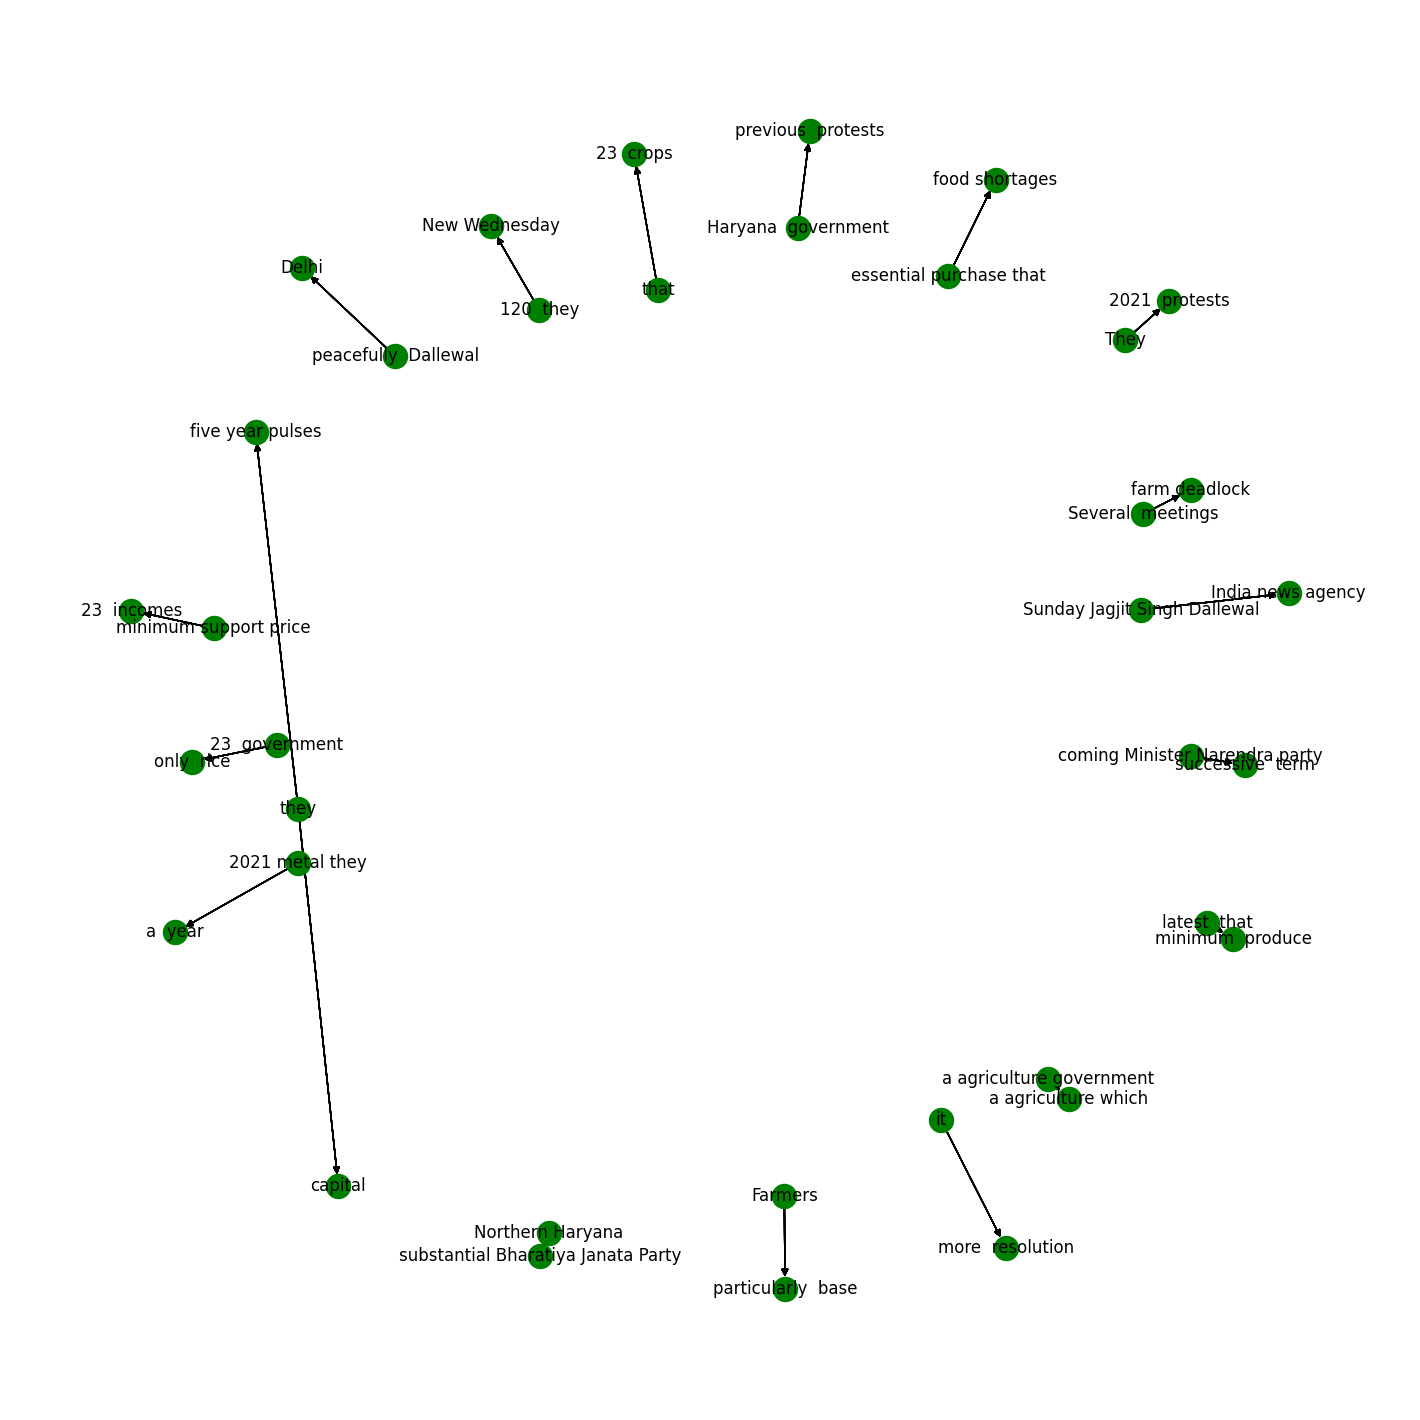

In [43]:
# plotting the network
plot.figure(figsize=(14, 14))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()